In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
future_lookup_period = 7
percent_threashold = 0
length = 90 # Length of the output sequences (in number of timesteps)
epoches = 10

In [3]:
def import_stock_data(tickers, start_date, end_date = datetime.today()):  
    if len([tickers]) == 1:
        # Import get_history function from nsepy module
        from nsepy import get_history

        data = get_history(symbol=tickers[0],
                        start=start_date,
                        end=end_date,
                        futures=False,
                        index=True)
    return(data)

In [4]:
data = import_stock_data(['NIFTY'], start_date=datetime(2015, 1, 1), end_date=datetime(2019, 12, 31))

In [5]:
data.describe()

,Open,High,Low,Close,Volume,Turnover
count,1234.000000,1234.000000,1234.000000,1234.000000,1.234000e+03,1.234000e+03
mean,9634.304417,9674.240802,9576.143071,9625.221029,2.656429e+08,1.203409e+11
std,1398.167171,1400.553522,1392.636626,1396.694971,1.564239e+08,5.478834e+10
min,7023.650000,7034.200000,6825.800000,6970.600000,1.661087e+07,8.058900e+09
25%,8376.837500,8413.225000,8322.437500,8361.512500,1.692134e+08,8.089255e+10
50%,9656.725000,9681.400000,9634.000000,9655.525000,2.116289e+08,1.034432e+11
75%,10815.337500,10858.200000,10751.875000,10802.075000,3.042141e+08,1.502535e+11
max,12274.900000,12293.900000,12252.750000,12271.800000,1.414837e+09,5.408153e+11


In [6]:
data.isnull().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Turnover    0
dtype: int64

In [7]:
data

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
2015-01-01,8272.80,8294.70,8248.75,8284.00,56560411,2.321880e+10
2015-01-02,8288.70,8410.60,8288.70,8395.45,101887024,4.715720e+10
2015-01-05,8407.95,8445.60,8363.90,8378.40,118160545,5.525520e+10
2015-01-06,8325.30,8327.85,8111.35,8127.35,172799618,8.089190e+10
2015-01-07,8118.65,8151.20,8065.45,8102.10,164075424,7.464330e+10
...,...,...,...,...,...,...
2019-12-24,12269.25,12283.70,12202.10,12214.55,470290298,1.386456e+11
2019-12-26,12211.85,12221.55,12118.85,12126.55,520326632,1.636231e+11
2019-12-27,12172.90,12258.45,12157.90,12245.80,383788556,1.367620e+11


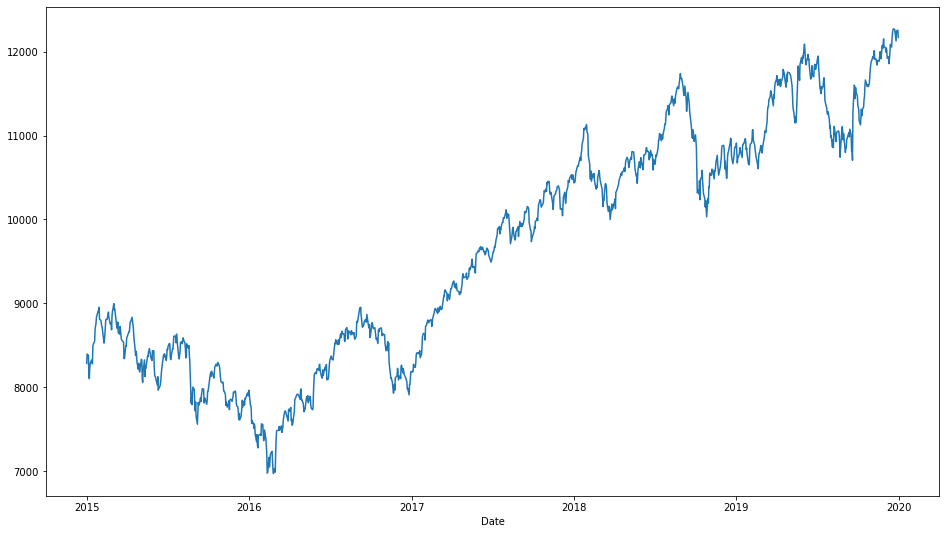

In [8]:
data['Close'].plot(figsize=(16,9))

In [9]:
data['shifted'] = data['Close'].shift(periods=-future_lookup_period)

In [10]:
data.tail(20)

,Open,High,Low,Close,Volume,Turnover,shifted
Date,,,,,,,
2019-12-03,12067.65,12068.60,11956.40,11994.20,605789334,1.820376e+11,11971.80
2019-12-04,11969.95,12054.70,11935.30,12043.20,747193818,2.213283e+11,12086.70
2019-12-05,12071.25,12081.20,11998.75,12018.40,562228745,1.958981e+11,12053.95
2019-12-06,12047.35,12057.05,11888.85,11921.50,609221205,1.824549e+11,12165.00
2019-12-09,11939.10,11981.95,11888.05,11937.50,599115748,1.667287e+11,12221.65
2019-12-10,11950.50,11953.20,11844.70,11856.80,650219487,1.651463e+11,12259.70
2019-12-11,11867.35,11923.20,11832.30,11910.15,997655048,1.876057e+11,12271.80
2019-12-12,11944.30,12005.50,11934.00,11971.80,752617138,1.840122e+11,12262.75
2019-12-13,12026.40,12098.85,12023.60,12086.70,597712516,2.062680e+11,12214.55


In [11]:
data['returns'] = ((data['shifted'] - data['Close'])/data['Close'])*100

In [12]:
data.dropna(inplace=True)

In [13]:
def return_tagger(returns):
    if returns > percent_threashold:
        return [1,0]
    elif returns <= percent_threashold:
        return [0,1]

In [14]:
data['y'] =  data['returns'].map(return_tagger)

In [15]:
data

,Open,High,Low,Close,Volume,Turnover,shifted,returns,y
Date,,,,,,,,,
2015-01-01,8272.80,8294.70,8248.75,8284.00,56560411,2.321880e+10,8323.00,0.470787,"[1, 0]"
2015-01-02,8288.70,8410.60,8288.70,8395.45,101887024,4.715720e+10,8299.40,-1.144072,"[0, 1]"
2015-01-05,8407.95,8445.60,8363.90,8378.40,118160545,5.525520e+10,8277.55,-1.203690,"[0, 1]"
2015-01-06,8325.30,8327.85,8111.35,8127.35,172799618,8.089190e+10,8494.15,4.513156,"[1, 0]"
2015-01-07,8118.65,8151.20,8065.45,8102.10,164075424,7.464330e+10,8513.80,5.081399,"[1, 0]"
...,...,...,...,...,...,...,...,...,...
2019-12-13,12026.40,12098.85,12023.60,12086.70,597712516,2.062680e+11,12214.55,1.057774,"[1, 0]"
2019-12-16,12131.35,12134.65,12046.30,12053.95,437703921,1.611034e+11,12126.55,0.602292,"[1, 0]"
2019-12-17,12082.45,12182.75,12070.35,12165.00,499585789,2.096879e+11,12245.80,0.664201,"[1, 0]"


In [16]:
data.drop(columns=['Turnover', 'shifted', 'returns'], inplace = True)

In [17]:
data.head()

,Open,High,Low,Close,Volume,y
Date,,,,,,
2015-01-01,8272.80,8294.70,8248.75,8284.00,56560411,"[1, 0]"
2015-01-02,8288.70,8410.60,8288.70,8395.45,101887024,"[0, 1]"
2015-01-05,8407.95,8445.60,8363.90,8378.40,118160545,"[0, 1]"
2015-01-06,8325.30,8327.85,8111.35,8127.35,172799618,"[1, 0]"
2015-01-07,8118.65,8151.20,8065.45,8102.10,164075424,"[1, 0]"


In [18]:
#data.groupby('y')['Close'].count()

In [19]:
vix_data = import_stock_data(['INDIAVIX'], start_date=datetime(2015, 1, 1), end_date=datetime(2019, 12, 31))

In [20]:
vix_data

,Open,High,Low,Close,Previous,Change,%Change
Date,,,,,,,
,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,15.1200,15.5075,14.7550,15.0250,15.1200,-0.10,-0.0063
2015-01-02,15.0250,15.0250,13.4825,13.7950,15.0250,-1.23,-0.0819
2015-01-05,13.7950,14.4050,13.1525,14.1525,13.7950,0.36,0.0259
2015-01-06,14.1525,17.8700,13.4575,17.4200,14.1525,3.27,0.2309
...,...,...,...,...,...,...,...
2019-12-24,11.9575,13.3100,10.8875,11.6250,11.9575,-0.33,-0.0278
2019-12-26,11.6250,12.3475,10.8425,11.1225,11.6250,-0.50,-0.0432
2019-12-27,11.1225,11.4675,10.4250,10.5250,11.1225,-0.60,-0.0537


In [21]:
vix_data.describe()

,Open,High,Low,Close,Previous,Change,%Change
count,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000
mean,15.690638,16.325419,14.152826,15.687646,15.691193,-0.001499,0.001061
std,3.083677,3.343433,2.895551,3.086004,3.083942,0.869554,0.050168
min,10.447500,10.807500,8.755000,10.447500,10.447500,-8.230000,-0.297700
25%,13.570000,14.005625,12.000625,13.555000,13.570000,-0.397500,-0.025500
50%,15.426250,15.965000,13.905000,15.418750,15.426250,-0.040000,-0.002450
75%,17.170000,17.939375,15.717500,17.177500,17.177500,0.340000,0.023175
max,28.717500,35.570000,26.375000,28.717500,28.717500,11.020000,0.643600


In [22]:
# Use median when we have outliers in our boxplot
vix_data=vix_data.mask(vix_data==0).fillna(vix_data.median())

In [24]:
vix_data.describe()

,Open,High,Low,Close,Previous,Change,%Change
count,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000
mean,15.687672,16.321376,14.150046,15.684629,15.688221,-0.002540,0.000992
std,3.066444,3.324828,2.879370,3.068763,3.066708,0.864681,0.049889
min,10.447500,10.807500,8.755000,10.447500,10.447500,-8.230000,-0.297700
25%,13.591875,14.032500,12.026875,13.586250,13.591875,-0.390000,-0.025400
50%,15.426250,15.965000,13.905000,15.418750,15.426250,-0.040000,-0.002450
75%,17.156250,17.895625,15.693750,17.161875,17.161875,0.330000,0.022700
max,28.717500,35.570000,26.375000,28.717500,28.717500,11.020000,0.643600


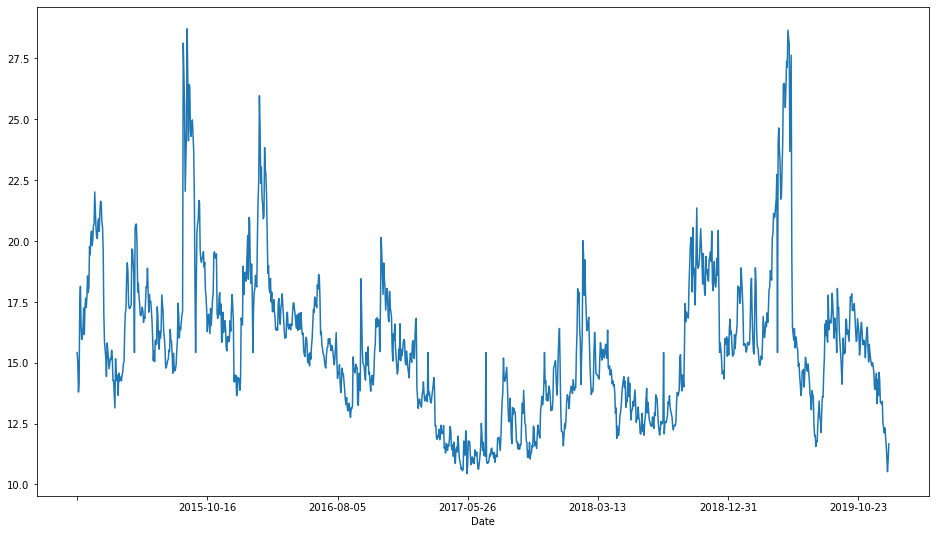

In [25]:
vix_data['Close'].plot(figsize=(16,9))

In [ ]:
#vix_data = vix_data[['Open', 'High', 'Low', 'Close']] / 100

In [26]:
vix_data.rename(columns = {"Open": "Vix_Open", "High": "Vix_High", "Low": "Vix_Low", "Close": "Vix_Close"}, inplace=True)

In [27]:
vix_data.head()

,Vix_Open,Vix_High,Vix_Low,Vix_Close,Previous,Change,%Change
Date,,,,,,,
,15.42625,15.9650,13.9050,15.41875,15.42625,-0.04,-0.00245
2015-01-01,15.12000,15.5075,14.7550,15.02500,15.12000,-0.10,-0.00630
2015-01-02,15.02500,15.0250,13.4825,13.79500,15.02500,-1.23,-0.08190
2015-01-05,13.79500,14.4050,13.1525,14.15250,13.79500,0.36,0.02590
2015-01-06,14.15250,17.8700,13.4575,17.42000,14.15250,3.27,0.23090


In [28]:
data = data.join(vix_data)

In [29]:
data

,Open,High,Low,Close,Volume,y,Vix_Open,Vix_High,Vix_Low,Vix_Close,Previous,Change,%Change
Date,,,,,,,,,,,,,
2015-01-01,8272.80,8294.70,8248.75,8284.00,56560411,"[1, 0]",15.1200,15.5075,14.7550,15.0250,15.1200,-0.10,-0.0063
2015-01-02,8288.70,8410.60,8288.70,8395.45,101887024,"[0, 1]",15.0250,15.0250,13.4825,13.7950,15.0250,-1.23,-0.0819
2015-01-05,8407.95,8445.60,8363.90,8378.40,118160545,"[0, 1]",13.7950,14.4050,13.1525,14.1525,13.7950,0.36,0.0259
2015-01-06,8325.30,8327.85,8111.35,8127.35,172799618,"[1, 0]",14.1525,17.8700,13.4575,17.4200,14.1525,3.27,0.2309
2015-01-07,8118.65,8151.20,8065.45,8102.10,164075424,"[1, 0]",17.4200,19.0700,16.5025,18.1400,17.4200,0.72,0.0413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-13,12026.40,12098.85,12023.60,12086.70,597712516,"[1, 0]",13.3475,14.6700,12.1850,13.3000,13.3475,-0.05,-0.0036
2019-12-16,12131.35,12134.65,12046.30,12053.95,437703921,"[1, 0]",13.3000,14.1100,12.5000,13.4150,13.3000,0.12,0.0086
2019-12-17,12082.45,12182.75,12070.35,12165.00,499585789,"[1, 0]",13.4150,13.4250,11.9550,12.5175,13.4150,-0.90,-0.0669


In [30]:
data['y'] = data['y'].shift(periods=1)
data.dropna(inplace=True)

In [31]:
data.tail()

,Open,High,Low,Close,Volume,y,Vix_Open,Vix_High,Vix_Low,Vix_Close,Previous,Change,%Change
Date,,,,,,,,,,,,,
2019-12-13,12026.40,12098.85,12023.60,12086.70,597712516,"[1, 0]",13.3475,14.670,12.185,13.3000,13.3475,-0.05,-0.0036
2019-12-16,12131.35,12134.65,12046.30,12053.95,437703921,"[1, 0]",13.3000,14.110,12.500,13.4150,13.3000,0.12,0.0086
2019-12-17,12082.45,12182.75,12070.35,12165.00,499585789,"[1, 0]",13.4150,13.425,11.955,12.5175,13.4150,-0.90,-0.0669
2019-12-18,12197.00,12237.70,12163.45,12221.65,518854651,"[1, 0]",12.5175,12.715,11.390,12.3375,12.5175,-0.18,-0.0144
2019-12-19,12223.40,12268.35,12191.15,12259.70,623049839,"[1, 0]",12.3375,12.415,11.325,12.1225,12.3375,-0.22,-0.0174


In [32]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume', 'Vix_Open', 'Vix_High', 'Vix_Low', 'Vix_Close']])

In [33]:
import joblib
joblib.dump(sc, 'scaler.gz')
#my_scaler = joblib.load('scaler.gz')

['scaler.gz']

In [34]:
training_set_scaled

array([[0.24329054, 0.26296533, 0.27265696, ..., 0.17031802, 0.26830306,
        0.18322386],
       [0.26622434, 0.26965219, 0.28667282, ..., 0.14528016, 0.24957435,
        0.20279146],
       [0.25032934, 0.2471557 , 0.23960226, ..., 0.28520949, 0.26688422,
        0.38163656],
       ...,
       [0.97289293, 0.98364586, 0.97748516, ..., 0.10570419, 0.1816118 ,
        0.11330049],
       [0.99492283, 0.99414423, 0.99483724, ..., 0.0770318 , 0.14954597,
        0.10344828],
       [1.        , 1.        , 1.        , ..., 0.06491671, 0.14585698,
        0.09168035]])

In [35]:
# define generator
batch_size = 1 #Number of timeseries samples in each batch
stride = 1
generator = TimeseriesGenerator(training_set_scaled, data['y'].to_numpy(), length=length, batch_size=batch_size, stride=stride)

In [36]:
# What does the first batch look like?
X,y = generator[0]

In [37]:
print(f'Given the Array: \n{X}')
print(f'Predict this y: \n {y[0]}')

Given the Array: 
[[[0.24329054 0.26296533 0.27265696 0.26939366 0.0609888  0.25054735
   0.17031802 0.26830306 0.18322386]
  [0.26622434 0.26965219 0.28667282 0.26617005 0.07262749 0.18322386
   0.14528016 0.24957435 0.20279146]
  [0.25032934 0.2471557  0.23960226 0.21870451 0.11170491 0.20279146
   0.28520949 0.26688422 0.38163656]
  [0.21058705 0.21340619 0.23104737 0.21393054 0.10546543 0.38163656
   0.33366986 0.43969921 0.42104543]
  [0.2245781  0.23104038 0.25003029 0.23898206 0.09096662 0.42104543
   0.29611307 0.37613507 0.32977559]
  [0.24266551 0.24246535 0.25441024 0.24841655 0.09726727 0.32977559
   0.24634023 0.32392168 0.30145047]
  [0.24380018 0.2480632  0.26462393 0.25569568 0.06189487 0.30145047
   0.27218576 0.31881385 0.30993432]
  [0.25433915 0.25265802 0.26878023 0.25123367 0.08078164 0.30993432
   0.24240283 0.33016459 0.33032293]
  [0.24685802 0.24688822 0.26295582 0.24710253 0.09584339 0.33032293
   0.28218072 0.33513053 0.37219485]
  [0.26940718 0.28522301 0.2

In [38]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(50,input_shape=(length,training_set_scaled.shape[1]), return_sequences = True))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Final Prediction (one neuron per feature)
model.add(Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 50)            12000     
_________________________________________________________________
dropout (Dropout)            (None, 90, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [40]:
history = model.fit(generator,epochs=epoches)

Epoch 1/10
1136/1136 [==============================] - 140s 118ms/step - loss: 0.6932 - accuracy: 0.5654
Epoch 2/10
1136/1136 [==============================] - 138s 121ms/step - loss: 0.6898 - accuracy: 0.5553
Epoch 3/10
1136/1136 [==============================] - 135s 119ms/step - loss: 0.6819 - accuracy: 0.5852
Epoch 4/10
1136/1136 [==============================] - 138s 121ms/step - loss: 0.6880 - accuracy: 0.5751
Epoch 5/10
1136/1136 [==============================] - 139s 122ms/step - loss: 0.6871 - accuracy: 0.5666
Epoch 6/10
1136/1136 [==============================] - 131s 115ms/step - loss: 0.6805 - accuracy: 0.5910
Epoch 7/10
1136/1136 [==============================] - 134s 118ms/step - loss: 0.6991 - accuracy: 0.5397
Epoch 8/10
1136/1136 [==============================] - 130s 114ms/step - loss: 0.6807 - accuracy: 0.5840
Epoch 9/10
1136/1136 [==============================] - 131s 116ms/step - loss: 0.6952 - accuracy: 0.5293
Epoch 10/10
1136/1136 [=======================

In [41]:
model.save("my_h5_model.h5")